In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
import pickle

# Exploratory Data Analysis:

In [2]:
# Load menu data
menu = pd.read_csv("XTern 2024 Artificial Intelegence Data Set - Menu.csv")
menu.rename(columns={"Unnamed: 0": "Item_Number"}, inplace=True)
menu.head()

,Item_Number,Item,Price,Calories
0,0,Hoosier BBQ Pulled Pork Sandwich,8,400
1,1,Cornbread Hush Puppies,5,250
2,2,Breaded Pork Tenderloin Sandwich,9,550
3,3,Indiana Pork Chili,7,300
4,4,Fried Catfish Basket,10,600


In [3]:
# Create a dictionary to transform orders into numerical variables
order_to_category_dict = {menu.Item[i]: menu.Item_Number[i] for i in range(len(menu.Item))}

In [4]:
# Load and explore the main dataset
data = pd.read_csv("XTern 2024 Artificial Intelegence Data Set - Xtern_TrainData.csv")
data.head()

,Year,Major,University,Time,Order
0,Year 2,Physics,Indiana State University,12,Fried Catfish Basket
1,Year 3,Chemistry,Ball State University,14,Sugar Cream Pie
2,Year 3,Chemistry,Butler University,12,Indiana Pork Chili
3,Year 2,Biology,Indiana State University,11,Fried Catfish Basket
4,Year 3,Business Administration,Butler University,12,Indiana Corn on the Cob (brushed with garlic b...


In [5]:
# Correctly preprocess the 'Year' column
data['Year'] = data['Year'].str.extract('(\d+)').astype(int)

## View Report.md file for EDA findings and potential use cases.

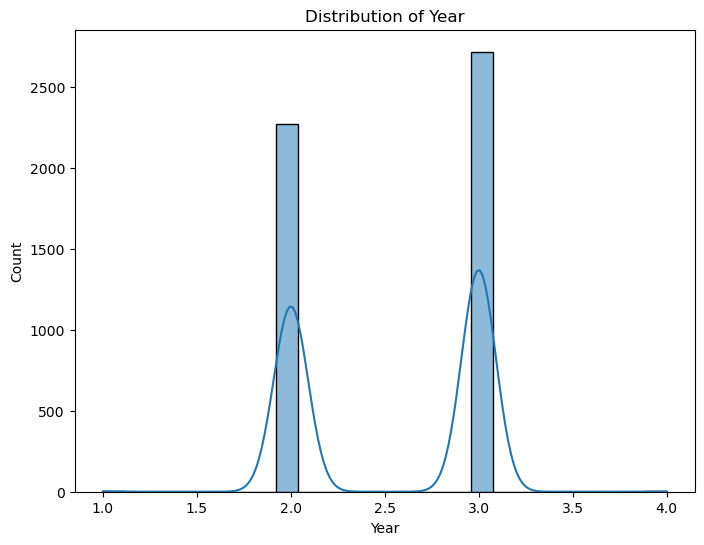

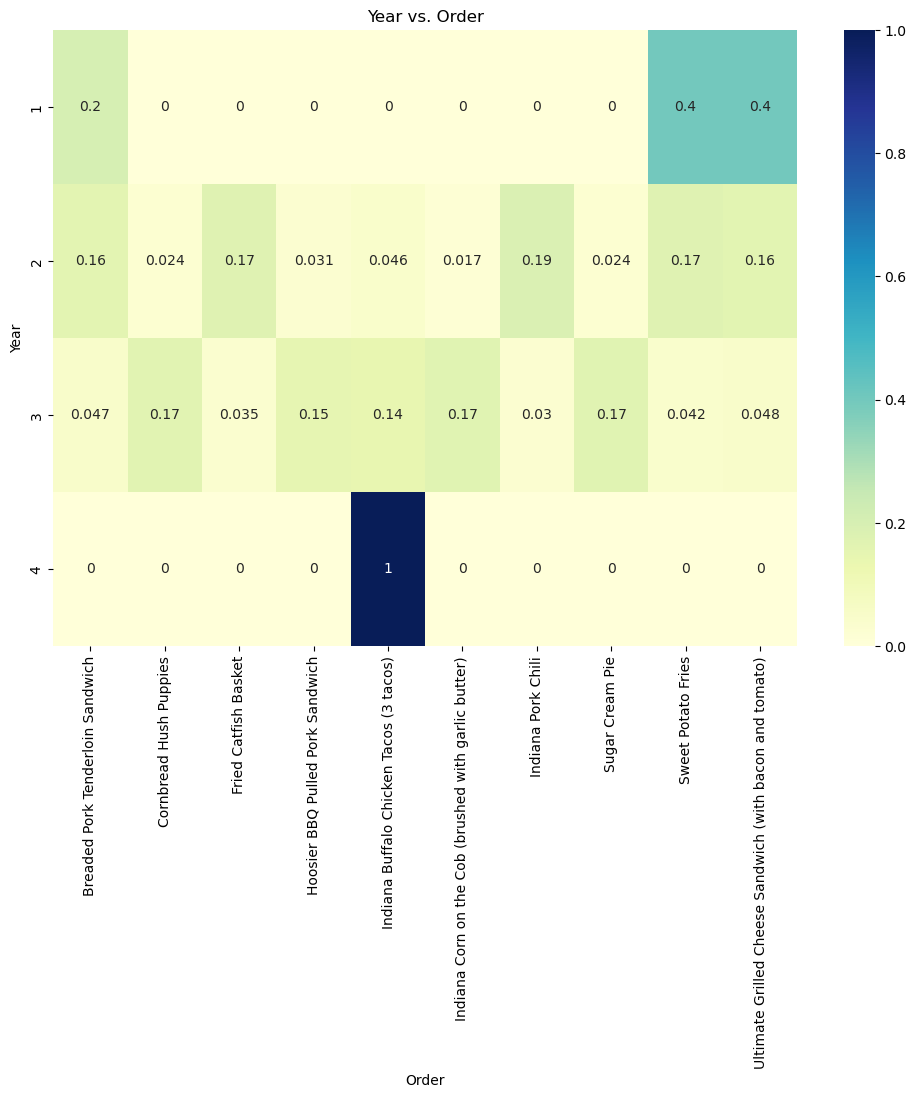

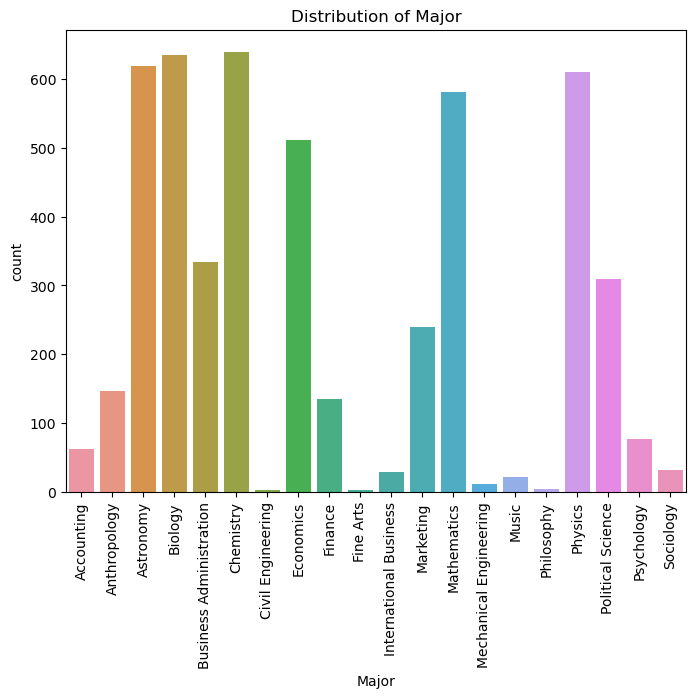

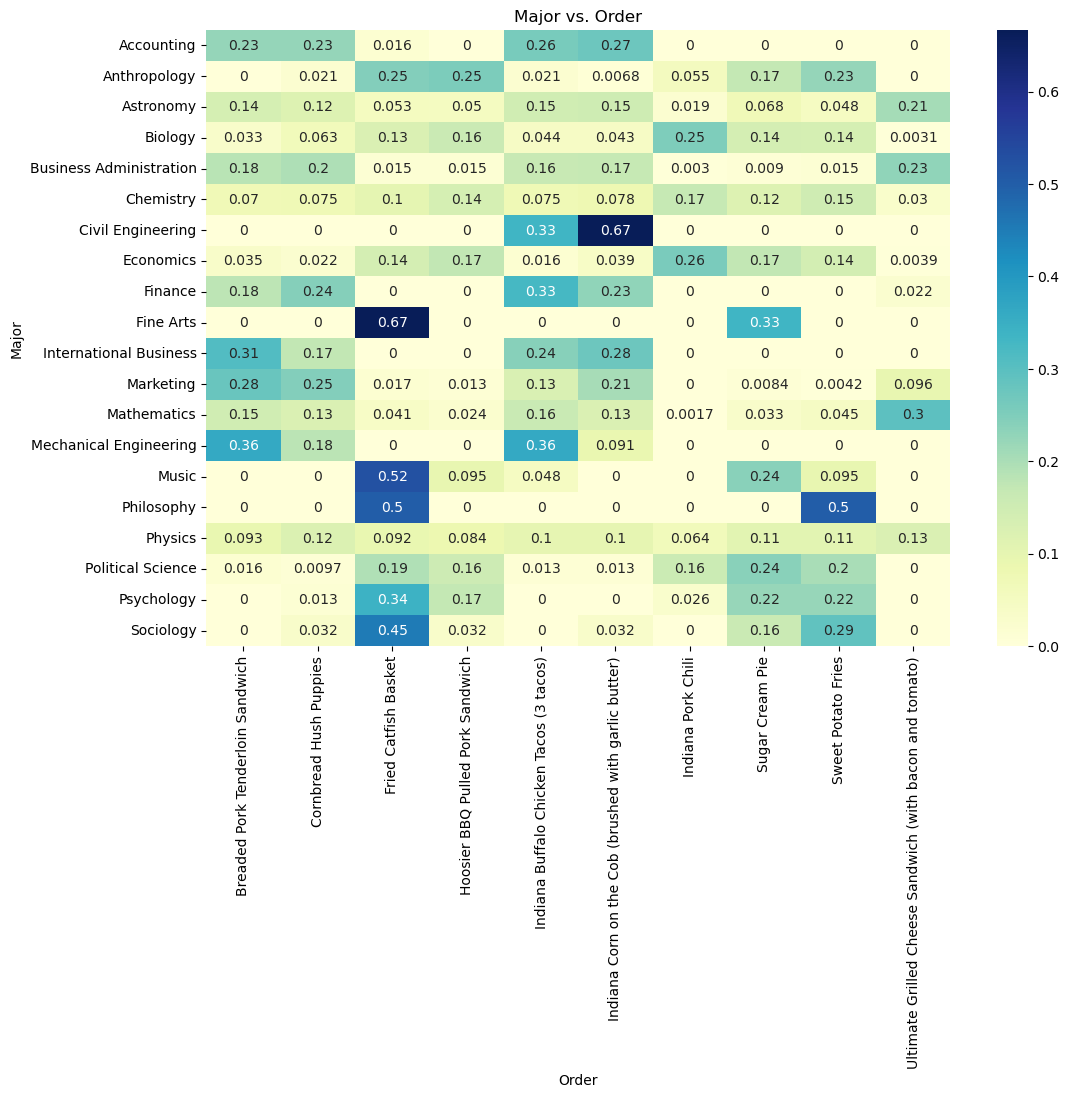

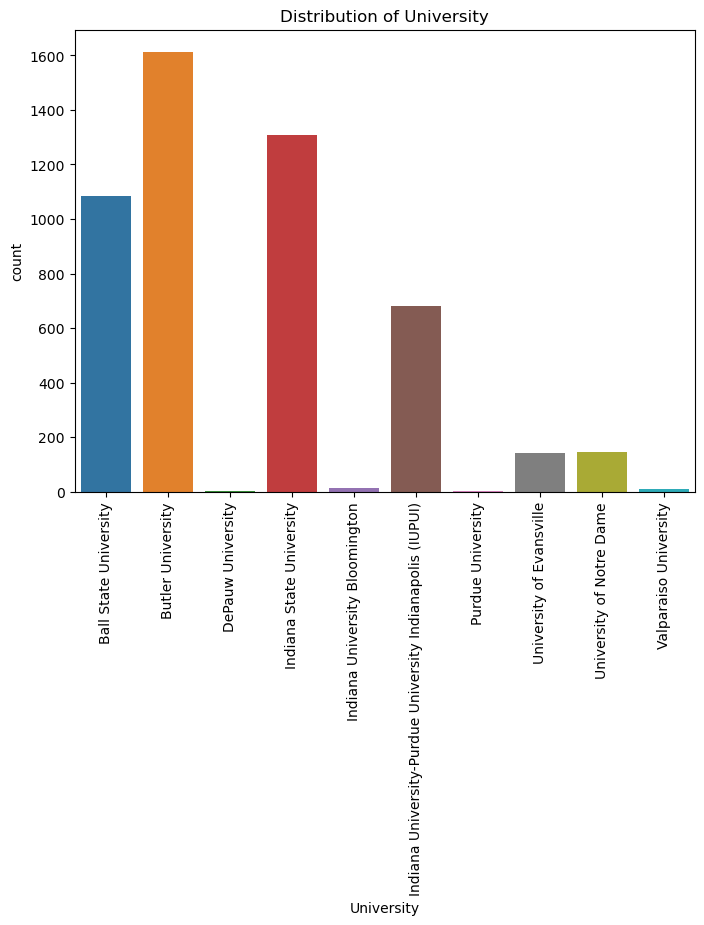

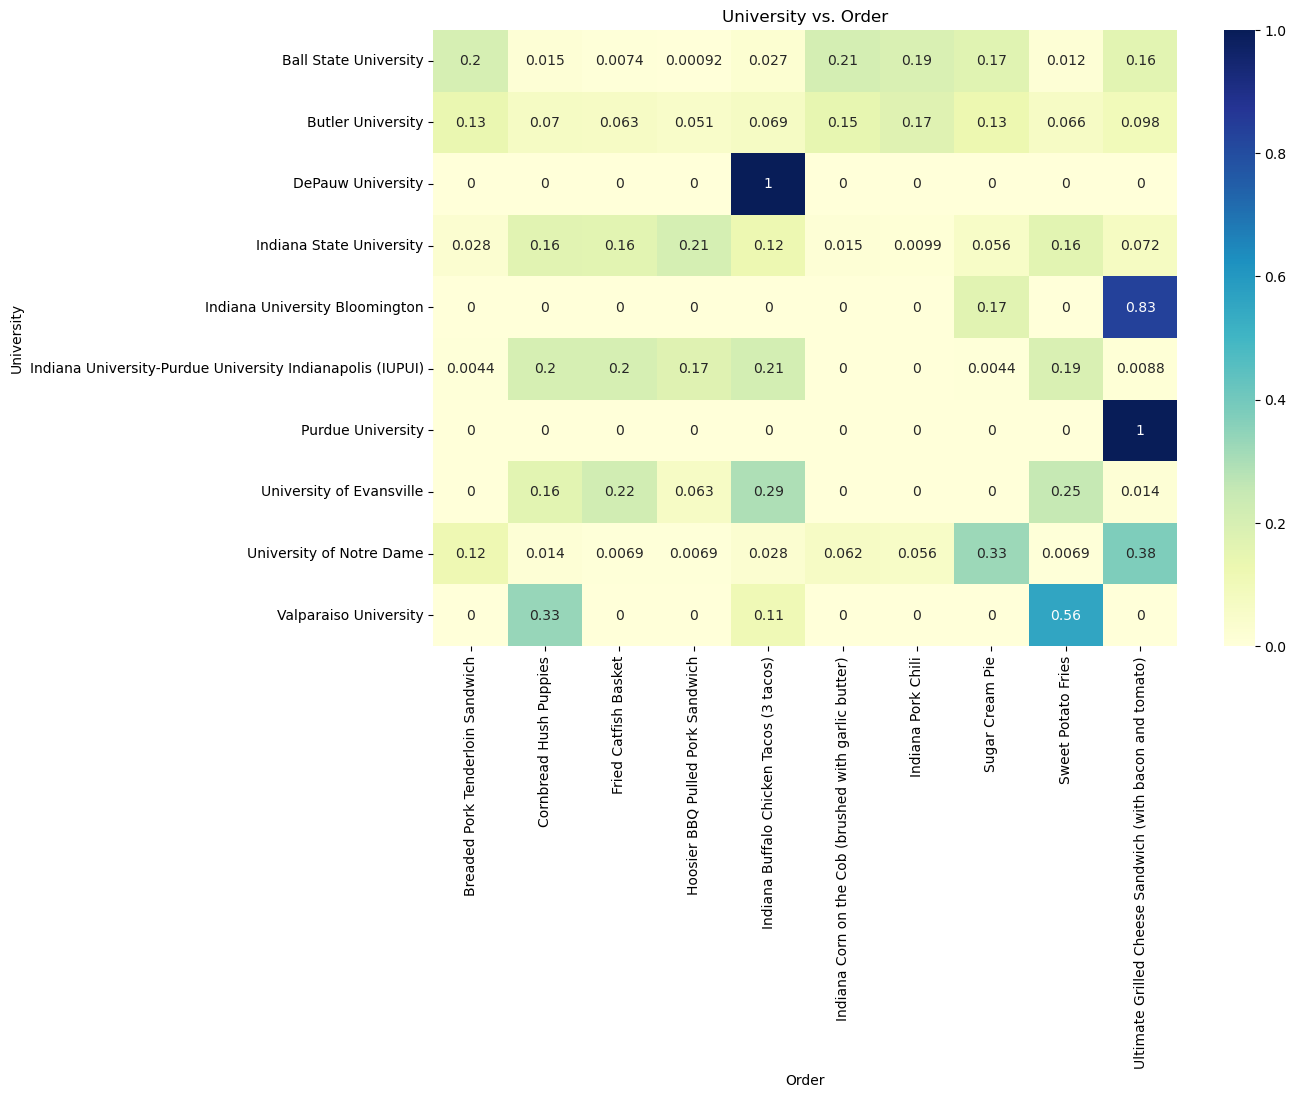

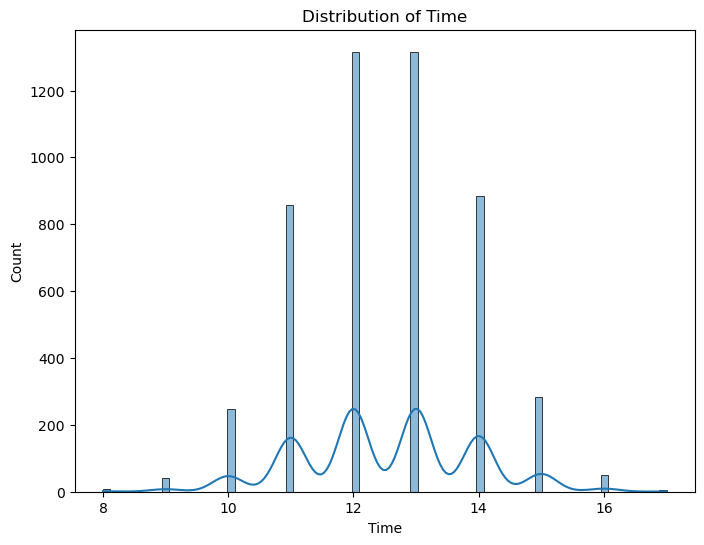

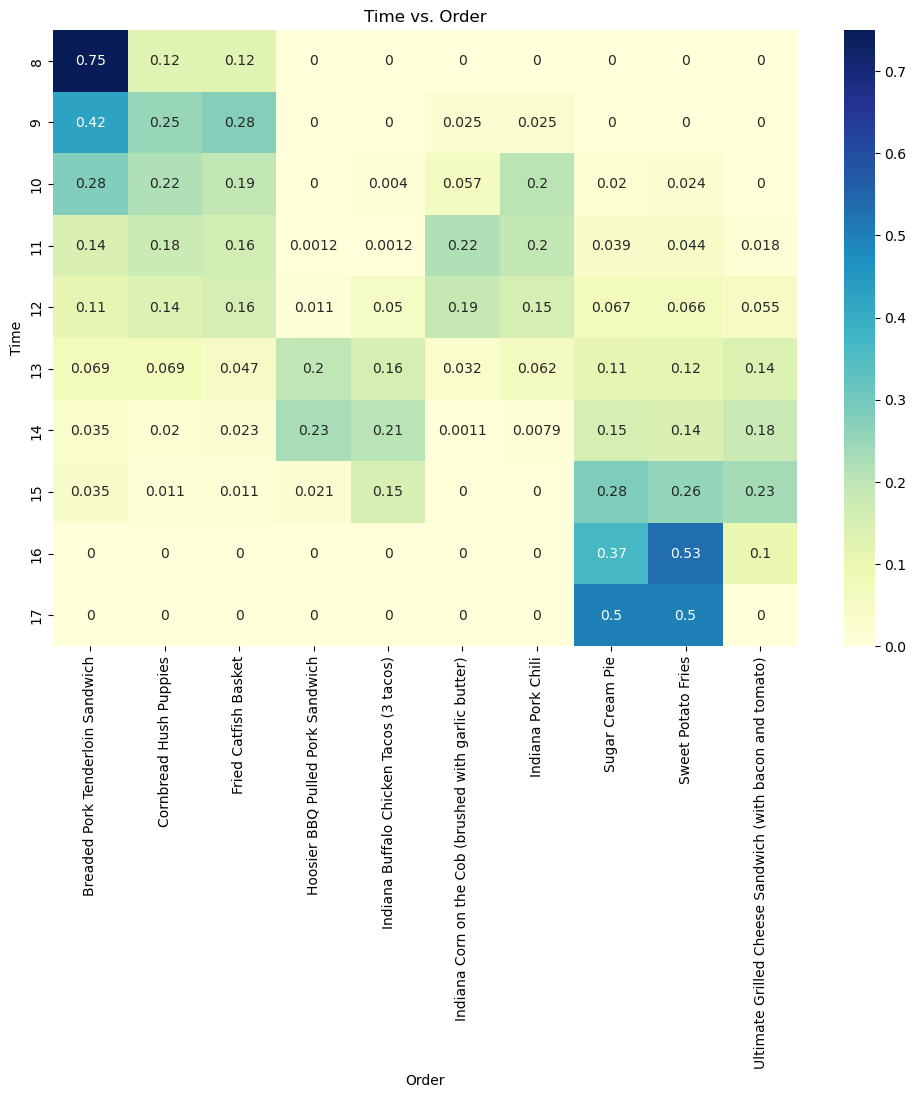

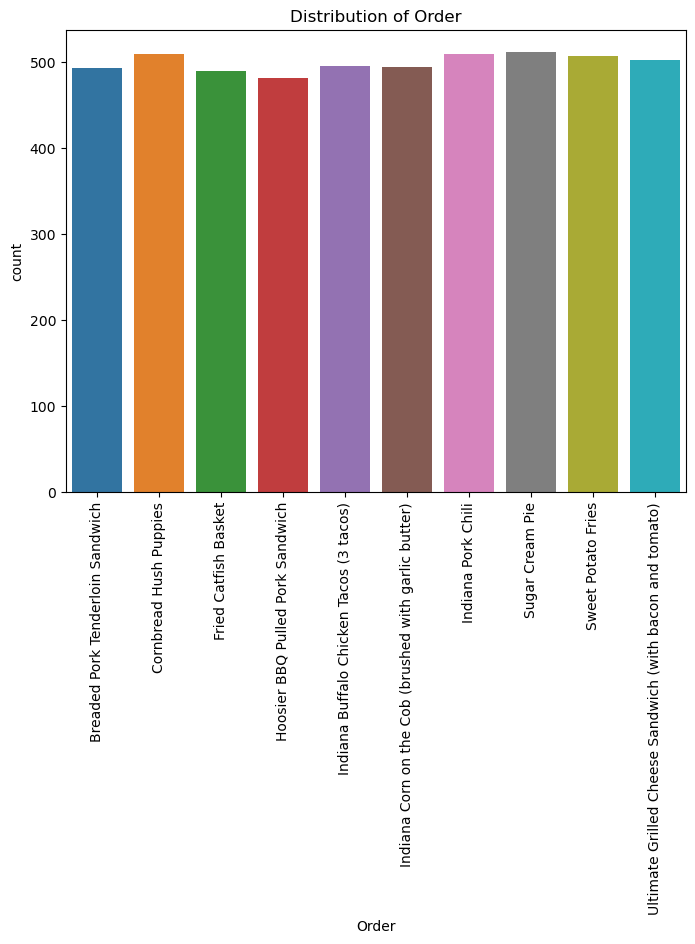

In [6]:
# Perform data exploration
def explore_data(data):
    """
    Perform exploratory data analysis and provide insights.
    """
    for col in data.columns:
        if data[col].dtype == 'object':
            # Handle non-numeric columns
            plt.figure(figsize=(8, 6))
            
            # Sort data by the column values for alphabetical order
            sorted_data = data.sort_values(by=col)
            
            sns.countplot(data=sorted_data, x=col)
            plt.title(f'Distribution of {col}')
            plt.xticks(rotation=90)
            plt.show()
        else:
            # Handle numeric columns
            plt.figure(figsize=(8, 6))
            sns.histplot(data=data, x=col, kde=True)
            plt.title(f'Distribution of {col}')
            plt.show()

        if col != 'Order':
            # Visualize feature interactions with the target variable
            plt.figure(figsize=(12, 8))
            sns.heatmap(pd.crosstab(data[col], data.Order, normalize='index'), annot=True, cmap="YlGnBu")
            plt.title(f'{col} vs. Order')
            plt.show()
            
explore_data(data)


## View Report.md file for considerations for implications of data collection, storage, and data biases.

# Building a Model:

In [7]:
# Preprocess the data
def preprocess_data(data, order_to_category_dict):
    """
    Preprocess the data to convert text features into numerical features.
    """
    data.replace({"Order": order_to_category_dict}, inplace=True)

    major_to_category_dict = {major: i for i, major in enumerate(data.Major.unique())}
    data.replace({"Major": major_to_category_dict}, inplace=True)
    
    uni_to_category_dict = {uni: i for i, uni in enumerate(data.University.unique())}
    data.replace({"University": uni_to_category_dict}, inplace=True)

    return data

In [8]:
# Prepare the preprocessed data for modeling
data = preprocess_data(data, order_to_category_dict)
X = data[['Year', 'Major', 'University', 'Time']]
y = data['Order']

In [9]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

In [10]:
# Model Selection and Training
def train_model(X_train, y_train, model_type='DecisionTree'):
    """
    Train a machine learning model.
    """
    if model_type == 'DecisionTree':
        model = DecisionTreeClassifier(random_state=0)
    elif model_type == 'RandomForest':
        model = RandomForestClassifier(random_state=0)
    elif model_type == 'KNeighbors':
        model = KNeighborsClassifier()
    elif model_type == 'SVM':
        model = SVC()

    model.fit(X_train, y_train)
    return model

In [11]:
# Hyperparameter Tuning:
def tune_hyperparameters(X_train, y_train, model):
    """
    Tune hyperparameters using GridSearchCV.
    """
    if isinstance(model, RandomForestClassifier):
        param_grid = {
            'n_estimators': [10, 50, 100, 200],
            'max_depth': [None, 10, 20, 30],
        }
    elif isinstance(model, DecisionTreeClassifier):
        param_grid = {
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
        }
    elif isinstance(model, KNeighborsClassifier):
        param_grid = {
            'n_neighbors': [3, 5, 7, 9],
        }
    elif isinstance(model, SVC):
        param_grid = {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
        }

    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    return best_model

In [12]:
# Train the Decision Tree model
dtc_model = train_model(X_train, y_train)

In [13]:
# Cross-Validation:
def cross_validate_model(model, X, y):
    """
    Perform cross-validation to assess model performance.
    """
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    return cv_scores

In [14]:
# Evaluate the Decision Tree model
dtc_cv_scores = cross_validate_model(dtc_model, X, y)

In [15]:
def save_model_to_pickle(model, filename):
    """
    Save the trained model to a pickle file.
    
    Parameters:
        model (object): Trained machine learning model.
        filename (str): Filepath to save the model.
    """
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

# Save the Decision Tree model to a pickle file
save_model_to_pickle(dtc_model, 'decision_tree_model.pkl')

In [16]:
# Performance Metrics:
def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model using various performance metrics.
    """
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    classification_rep = classification_report(y_test, y_pred)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'classification_report': classification_rep
    }

In [17]:
# Evaluate the Decision Tree model
dtc_evaluation = evaluate_model(dtc_model, X_test, y_test)

In [18]:
# Print model evaluation results
print("Decision Tree Model Evaluation:")
print("Accuracy:", dtc_evaluation['accuracy'])
print("Precision:", dtc_evaluation['precision'])
print("Recall:", dtc_evaluation['recall'])
print("F1 Score:", dtc_evaluation['f1'])
print("Classification Report:")
print(dtc_evaluation['classification_report'])

Decision Tree Model Evaluation:
Accuracy: 0.641
Precision: 0.6365852605805372
Recall: 0.641
F1 Score: 0.6362041511598523
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.73      0.73       108
           1       0.52      0.51      0.52        94
           2       0.47      0.48      0.47       101
           3       0.79      0.82      0.81       113
           4       0.70      0.65      0.67       105
           5       0.69      0.86      0.77        94
           6       0.57      0.51      0.54        97
           7       0.71      0.82      0.76        97
           8       0.59      0.44      0.50        93
           9       0.56      0.55      0.55        98

    accuracy                           0.64      1000
   macro avg       0.63      0.64      0.63      1000
weighted avg       0.64      0.64      0.64      1000



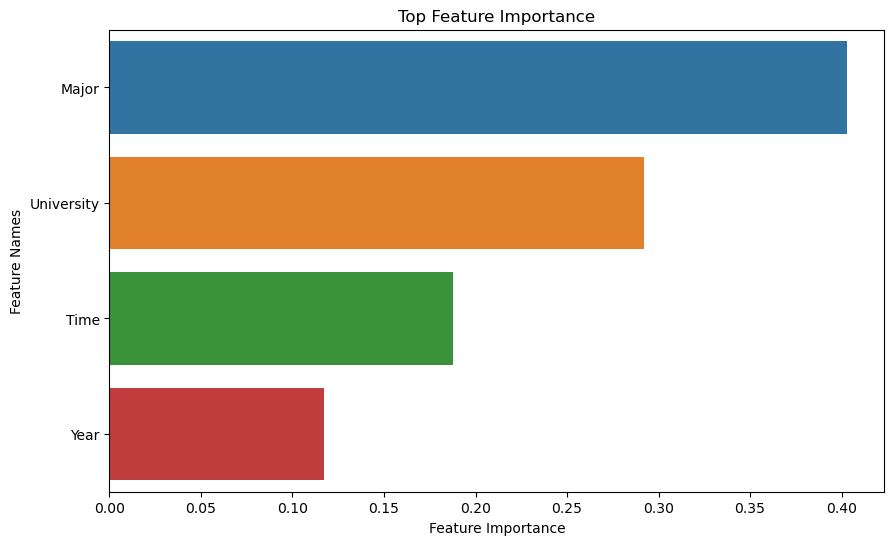

In [19]:
# (8) Model Interpretability:
# If applicable, consider using model interpretability techniques.

# Feature Importance Analysis for Decision Tree Model
def plot_feature_importance(model, feature_names, top_n=10):
    """
    Plot the feature importance for a decision tree model.
    """
    feature_importance = model.feature_importances_
    feature_names = np.array(feature_names)

    data = pd.DataFrame({'feature_names': feature_names, 'feature_importance': feature_importance})
    data.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=data['feature_importance'][:top_n], y=data['feature_names'][:top_n])
    plt.title('Top Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    plt.show()

# Plot feature importance for the Decision Tree model
plot_feature_importance(dtc_model, X_train.columns)

## View Report.md file for considerations for implications of data collection, storage, and data biases.

## View Report.md file for considerations for implementation.